<a href="https://colab.research.google.com/github/deinal/gcn-transition-matrix/blob/main/gcn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN Regression on a Directed Graph

In [1]:
!pip install torch_geometric

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, GraphNorm
from torch_geometric.data import Data, DataLoader

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Create dataloader

- Edge weights are calculated using a sine function applied to the difference in node features, scaled by the target_factor, and then transformed to an integer between 0 and 10.
- The target y is calculated as the mean of the target_factor plus an additional component that depends on both the node features and the edge weights.

In [3]:
Nnodes = 5
num_node_features = 10
num_graphs = 300

graphs = []

for _ in range(num_graphs):
    edge_indices = np.zeros((2, Nnodes * Nnodes), dtype=np.int64)
    edge_weights = np.zeros(Nnodes * Nnodes, dtype=np.float32)

    # Generating node features
    x = np.random.rand(Nnodes, num_node_features)

    # Factor to relate node features to the target
    target_factor = np.random.rand(num_node_features)

    ii = 0
    for i in range(Nnodes):
        for j in range(Nnodes):
            edge_indices[:, ii] = np.array([i, j])

            # Generating edge weights based on node features and the target factor
            edge_weights[ii] = int(abs(np.sum(np.sin((x[i] - x[j]) * target_factor))) * 10) % 11
            ii += 1

    edge_index = torch.tensor(edge_indices, dtype=torch.long)
    edge_weight = torch.tensor(edge_weights, dtype=torch.float)
    x = torch.tensor(x, dtype=torch.float)

    # Target as a function of the target factor, node features, and edge weights
    target_component = np.sum(np.sin(x.numpy()) * target_factor) / Nnodes
    y = torch.tensor([np.mean(target_factor) + target_component], dtype=torch.float).view(1, -1)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    graphs.append(data)

dataset = graphs

## Plot directed graph with edge weights

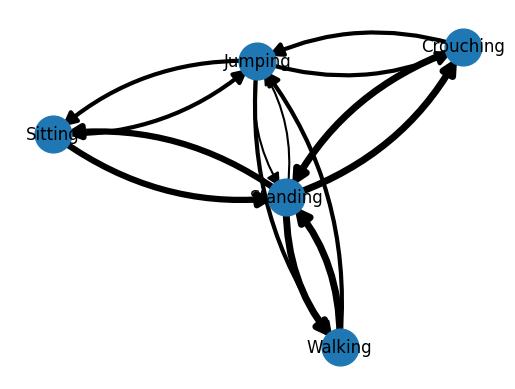

In [4]:
# Extract the first graph
graph = dataset[0]
transition_matrix = graph.edge_attr.view(Nnodes, Nnodes).numpy()

G = nx.DiGraph()

actions = ["Sitting", "Standing", "Walking", "Crouching", "Jumping"]
for i in range(Nnodes):
    G.add_node(i, action=actions[i])

for i in range(Nnodes):
    for j in range(Nnodes):
        if transition_matrix[i, j] > 0:
            G.add_edge(i, j, weight=transition_matrix[i, j])

# Draw the graph
pos = nx.spring_layout(G)
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}

fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=700)
edges = nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle='arc3,rad=0.2', edge_color='black', width=[d['weight']*0.5 for u, v, d in G.edges(data=True)], arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos, ax=ax, labels={i: G.nodes[i]['action'] for i in G.nodes})
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

plt.axis('off')
plt.show()

## Define models

Relevant papers

- Graph Convolutional Networks https://arxiv.org/abs/1609.02907
- Graph Attention Networks https://arxiv.org/abs/1710.10903
- Residual connection https://arxiv.org/abs/1512.03385
- Dropout https://jmlr.org/papers/v15/srivastava14a.html
- GraphNorm https://arxiv.org/abs/2009.03294
- GELU https://arxiv.org/abs/1606.08415

In [5]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64, improved=True)
        self.norm1 = GraphNorm(64)
        self.conv2 = GCNConv(64, 32, improved=True)
        self.norm2 = GraphNorm(32)
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GCN layer
        x = F.gelu(self.norm1(self.conv1(x, edge_index, edge_weight)))
        x = F.dropout(x, p=0.05, training=self.training)

        # Second GCN layer
        x = F.gelu(self.norm2(self.conv2(x, edge_index, edge_weight)))
        x = global_mean_pool(x, batch)

        # Fully connected layer
        x = self.fc(x)

        return x

In [6]:
class DeepGCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(DeepGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64, improved=True)
        self.norm1 = GraphNorm(64)
        self.conv2 = GCNConv(64, 32, improved=True)
        self.norm2 = GraphNorm(32)
        self.conv3 = GCNConv(32, 16, improved=True)
        self.norm3 = GraphNorm(16)
        self.fc = torch.nn.Linear(16, 1)

        # Linear transformations for skip connections
        self.skip1 = torch.nn.Linear(num_node_features, 64)
        self.skip2 = torch.nn.Linear(64, 32)
        self.skip3 = torch.nn.Linear(32, 16)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GCN layer with skip connection
        x1 = F.gelu(self.norm1(self.conv1(x, edge_index, edge_weight)))
        x1 += self.skip1(x)
        x1 = F.dropout(x1, p=0.05, training=self.training)

        # Second GCN layer with skip connection
        x2 = F.gelu(self.norm2(self.conv2(x1, edge_index, edge_weight)))
        x2 += self.skip2(x1)
        x2 = F.dropout(x2, p=0.05, training=self.training)

        # Third GCN layer with skip connection
        x3 = F.gelu(self.norm3(self.conv3(x2, edge_index, edge_weight)))
        x3 += self.skip3(x2)
        x3 = global_mean_pool(x3, batch)

        # Fully connected layer
        x = self.fc(x3)

        return x

In [7]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 64)
        self.norm1 = GraphNorm(64)
        self.conv2 = GATConv(64, 32)
        self.norm2 = GraphNorm(32)
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.gelu(self.norm1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.05, training=self.training)

        x = F.gelu(self.norm2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)

        x = self.fc(x)

        return x

In [8]:
class GATnoSelfLoop(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GATnoSelfLoop, self).__init__()
        self.conv1 = GATConv(num_node_features, 64, add_self_loops=False)
        self.norm1 = GraphNorm(64)
        self.conv2 = GATConv(64, 32, add_self_loops=False)
        self.norm2 = GraphNorm(32)
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.gelu(self.norm1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.05, training=self.training)

        x = F.gelu(self.norm2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)

        x = self.fc(x)

        return x

## Train

In [9]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                output = model(data)
                loss = loss_fn(output, data.y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

In [10]:
# Initialize models
models = {
    'GCN': GCN(num_node_features),
    'DeepGCN': DeepGCN(num_node_features),
    'GAT': GAT(num_node_features),
    'GATnoSelfLoop': GATnoSelfLoop(num_node_features),
}

# Initialize optimizers
optimizers = {name: torch.optim.Adam(model.parameters(), lr=1e-4) for name, model in models.items()}

# Loss function
loss_fn = torch.nn.MSELoss()

# Split the dataset into training and validation sets
train_dataset = dataset[:200]
val_dataset = dataset[200:]
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Train and evaluate models
losses = {}
for name, model in models.items():
    print(f"Training {name}...")
    train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, optimizers[name], loss_fn)
    losses[name] = {'train': train_losses, 'val': val_losses}

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training GCN...
Epoch 1/10, Loss: 7.3555, Validation Loss: 7.3541
Epoch 2/10, Loss: 5.8521, Validation Loss: 5.8115
Epoch 3/10, Loss: 4.4295, Validation Loss: 4.2846
Epoch 4/10, Loss: 3.0484, Validation Loss: 2.8250
Epoch 5/10, Loss: 1.8120, Validation Loss: 1.6252
Epoch 6/10, Loss: 0.9653, Validation Loss: 0.8790
Epoch 7/10, Loss: 0.5233, Validation Loss: 0.5304
Epoch 8/10, Loss: 0.3547, Validation Loss: 0.3910
Epoch 9/10, Loss: 0.2906, Validation Loss: 0.3436
Epoch 10/10, Loss: 0.2700, Validation Loss: 0.3195
Training DeepGCN...
Epoch 1/10, Loss: 4.1230, Validation Loss: 1.7124
Epoch 2/10, Loss: 0.4732, Validation Loss: 0.2853
Epoch 3/10, Loss: 0.2575, Validation Loss: 0.2894
Epoch 4/10, Loss: 0.2500, Validation Loss: 0.3162
Epoch 5/10, Loss: 0.2464, Validation Loss: 0.3193
Epoch 6/10, Loss: 0.2523, Validation Loss: 0.3116
Epoch 7/10, Loss: 0.2415, Validation Loss: 0.3088
Epoch 8/10, Loss: 0.2479, Validation Loss: 0.2853
Epoch 9/10, Loss: 0.2441, Validation Loss: 0.3068
Epoch 10/10, 

## Plot loss

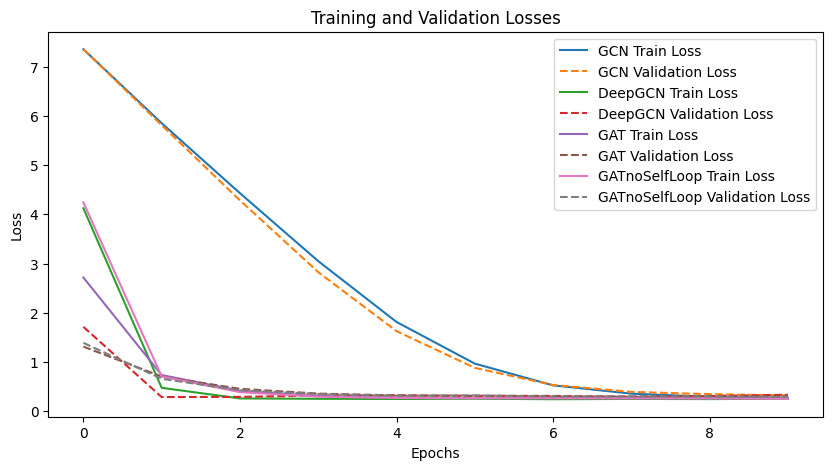

In [11]:
epochs = len(next(iter(losses.values()))['train'])

# Plotting
plt.figure(figsize=(10, 5))
for name, loss in losses.items():
    plt.plot(range(epochs), loss['train'], label=f'{name} Train Loss')
    plt.plot(range(epochs), loss['val'], label=f'{name} Validation Loss', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()